# Twin Delayed Deep Deterministic Policy Gradients (TD3)
> Alik604

Twin Delayed Deep Deterministic Policy Gradients (TD3) is a state of the art actor critic algorithm for mastering environments with continuous action spaces. It's based on the deep deterministic policy gradients algorithm, but deals with the problem of overestimation bias that arises from the use of deep neural networks as function approximators.

### Source 
[Video](https://www.youtube.com/watch?v=1lZOB2S17LU)
[code](https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning/PolicyGradient/TD3)

In [1]:
import numpy as np

import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import os
import gym

import matplotlib.pyplot as plt

In [2]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done
        self.reward_memory[index] = reward
        self.action_memory[index] = action

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [3]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions,
            name, chkpt_dir='./save/td3'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = nn.Linear(self.input_dims[0] + n_actions, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q1 = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        q1_action_value = self.fc1(T.cat([state, action], dim=1))
        q1_action_value = F.relu(q1_action_value)
        q1_action_value = self.fc2(q1_action_value)
        q1_action_value = F.relu(q1_action_value)

        q1 = self.q1(q1_action_value)

        return q1

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims,
            n_actions, name, chkpt_dir='./save/td3'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        prob = self.fc1(state)
        prob = F.relu(prob)
        prob = self.fc2(prob)
        prob = F.relu(prob)

        mu = T.tanh(self.mu(prob))

        return mu

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

In [4]:
class Agent():
    def __init__(self, alpha, beta, input_dims, tau, env,
            gamma=0.99, update_actor_interval=2, warmup=1000,
            n_actions=2, max_size=1000000, layer1_size=400,
            layer2_size=300, batch_size=100, noise=0.1):
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.gamma = gamma
        self.tau = tau
        self.max_action = env.action_space.high
        self.min_action = env.action_space.low
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.learn_step_cntr = 0
        self.time_step = 0
        self.warmup = warmup
        self.n_actions = n_actions
        self.update_actor_iter = update_actor_interval

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                        layer2_size, n_actions=n_actions, name='actor')

        self.critic_1 = CriticNetwork(beta, input_dims, layer1_size,
                        layer2_size, n_actions=n_actions, name='critic_1')
        self.critic_2 = CriticNetwork(beta, input_dims, layer1_size,
                        layer2_size, n_actions=n_actions, name='critic_2')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                    layer2_size, n_actions=n_actions, name='target_actor')
        self.target_critic_1 = CriticNetwork(beta, input_dims, layer1_size,
                layer2_size, n_actions=n_actions, name='target_critic_1')
        self.target_critic_2 = CriticNetwork(beta, input_dims, layer1_size,
                layer2_size, n_actions=n_actions, name='target_critic_2')

        self.noise = noise
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        if self.time_step < self.warmup:
            mu = T.tensor(np.random.normal(scale=self.noise, 
                                            size=(self.n_actions,)), device=self.device)
        else:
            state = T.tensor(observation, dtype=T.float, device=self.device)
            mu = self.actor.forward(state).to(self.device)
        mu_prime = mu + T.tensor(np.random.normal(scale=self.noise),
                                    dtype=T.float, device=self.device)

        mu_prime = T.clamp(mu_prime, self.min_action[0], self.max_action[0])
        self.time_step += 1

        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return 
        state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float, device=self.device)
        done = T.tensor(done, device=self.device)
        state_ = T.tensor(new_state, dtype=T.float, device=self.device)
        state = T.tensor(state, dtype=T.float, device=self.device)
        action = T.tensor(action, dtype=T.float, device=self.device)
        
        target_actions = self.target_actor.forward(state_)
        target_actions = target_actions + \
                T.clamp(T.tensor(np.random.normal(scale=0.2)), -0.5, 0.5)
        target_actions = T.clamp(target_actions, self.min_action[0], 
                                self.max_action[0])
        
        q1_ = self.target_critic_1.forward(state_, target_actions)
        q2_ = self.target_critic_2.forward(state_, target_actions)

        q1 = self.critic_1.forward(state, action)
        q2 = self.critic_2.forward(state, action)

        q1_[done] = 0.0
        q2_[done] = 0.0

        q1_ = q1_.view(-1)
        q2_ = q2_.view(-1)

        critic_value_ = T.min(q1_, q2_)

        target = reward + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()

        q1_loss = F.mse_loss(target, q1)
        q2_loss = F.mse_loss(target, q2)
        critic_loss = q1_loss + q2_loss
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        self.learn_step_cntr += 1

        if self.learn_step_cntr % self.update_actor_iter != 0:
            return

        self.actor.optimizer.zero_grad()
        actor_q1_loss = self.critic_1.forward(state, self.actor.forward(state))
        actor_loss = -T.mean(actor_q1_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_1_params = self.critic_1.named_parameters()
        critic_2_params = self.critic_2.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_1_params = self.target_critic_1.named_parameters()
        target_critic_2_params = self.target_critic_2.named_parameters()

        critic_1 = dict(critic_1_params)
        critic_2 = dict(critic_2_params)
        actor = dict(actor_params)
        target_actor = dict(target_actor_params)
        target_critic_1 = dict(target_critic_1_params)
        target_critic_2 = dict(target_critic_2_params)

        for name in critic_1:
            critic_1[name] = tau*critic_1[name].clone() + \
                    (1-tau)*target_critic_1[name].clone()

        for name in critic_2:
            critic_2[name] = tau*critic_2[name].clone() + \
                    (1-tau)*target_critic_2[name].clone()

        for name in actor:
            actor[name] = tau*actor[name].clone() + \
                    (1-tau)*target_actor[name].clone()

        self.target_critic_1.load_state_dict(critic_1)
        self.target_critic_2.load_state_dict(critic_2)
        self.target_actor.load_state_dict(actor)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.target_critic_1.save_checkpoint()
        self.target_critic_2.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic_1.load_checkpoint()
        self.critic_2.load_checkpoint()
        self.target_critic_1.load_checkpoint()
        self.target_critic_2.load_checkpoint()

In [5]:
def plot_learning_curve(scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-50):(i+1)])
    plt.plot( running_avg)
    plt.title('Running average of previous 50 scores')
    # plt.savefig(figure_file)
    plt.show()

In [8]:
env = gym.make('LunarLanderContinuous-v2')
agent = Agent(alpha=0.001, beta=0.001,
        input_dims=env.observation_space.shape, tau=0.005,
        env=env, batch_size=100, layer1_size=400, layer2_size=300,
        n_actions=env.action_space.shape[0])


best_score = 0 # env.reward_range[0]
score_history = []

agent.load_models()

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


episode  0 score 200.6 average score -38.9


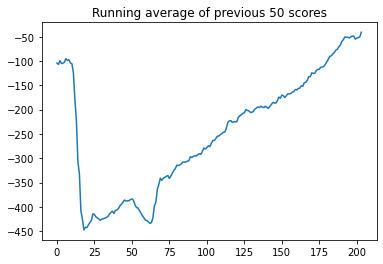

In [50]:
n_games = 8
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.remember(observation, action, reward, observation_, done)
        agent.learn()
        score += reward
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-50:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode ', i, 'score %.1f' % score,
            'average score %.1f' % avg_score)

plot_learning_curve(score_history, f'LunarLanderContinuous_{n_games}_games.png'
)

device(type='cuda', index=0)

In [9]:
for i in range(6):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        act = agent.choose_action(obs)
        new_state, reward, done, info = env.step(act)
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state
        env.render()
    env.close()

    score_history.append(score)
    avg_score = np.mean(score_history[-50:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode ', i, 'score %.2f' % score, 'trailing 50 games avg %.3f' % avg_score)

episode  0 score -156.06 trailing 50 games avg -156.064
episode  1 score -85.94 trailing 50 games avg -121.004
episode  2 score -196.83 trailing 50 games avg -146.279
episode  3 score -127.94 trailing 50 games avg -141.694
episode  4 score -125.37 trailing 50 games avg -138.428
episode  5 score -132.35 trailing 50 games avg -137.415
